# 设置参数
配置的参数,需要与采集数据时雷达配置的参数一致

In [9]:
import torch

n_RX = 4  # RX天线通道总数
n_samples = 64  # 采样点数
n_chirps = 255  # 每帧脉冲数
N = 64  # 距离向FFT点数
M = 64  # 多普勒向FFT点数
Q = 64  # 角度FFT

c = 3.0e8   # 光速
B = 3999.48e6  # 调频带宽
K = 99.987e12  # 调频斜率
T = B / K  # 调频周期
Tc = 140e-6  # chirp总周期
fs = 2.5e6  # 采样率
f0 = 77e9  # 初始频率
lambda_val = c / f0  # 雷达信号波长
d = lambda_val / 2  # 天线阵列间距

numADCBits = 16 # ADC位数
numLanes = 4    # 通道数
isReal = 0      # 是否为实数

num_classes = 8 # 类别数
num_samples = 500   # 每个类别的样本数
n_frames = 30   # 每个样本的帧数

# 是否静态杂波滤除
is_static_clutter_removal = 1

distance_axis = torch.arange(0, N) * fs * c / (2 * K * N)   # 距离轴
velocity_axis = torch.arange(-M/2, M/2) * lambda_val / Tc / M / 2   # 速度轴



# 特征提取
需要修改的参数有：
- `num_classes`：分类的类别数
- `directory_path`：数据集的路径
## 数据集要求
- 数据集的文件夹名为类别的标签

```shell
|-- 1
|   |-- 1.bin
|   |-- 2.bin
|   |-- ...
|-- 2
|   |-- 1.bin
|   |-- 2.bin
|   |-- ...
|-- ...
```

In [8]:
import os
import numpy as np
import glob
import numpy as np
import matplotlib.pyplot as plt
from RealTimeCollector.RealTimeCollector import RealTimeCollector
import scipy.io as sio

num_classes = 8 # 类别数
# directory_path = f'K:/手势识别数据集/{label}/'
directory_path = f'I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后/'
rtc = RealTimeCollector()

# 遍历所有类别的文件夹
for label in range(1, num_classes + 1):
    print(f"当前类别为：{label}")

    # 初始化变量
    range_profile = np.zeros((num_samples, n_frames, N), dtype=np.complex128)
    speed_profile = np.zeros((num_samples, n_frames, M), dtype=np.complex128)
    angle_profile = np.zeros((num_samples, n_frames, Q), dtype=np.complex128)


    bin_files = sorted(glob.glob(os.path.join(directory_path, '*.bin')))
    
    # 遍历数据集
    for i, bin_file in enumerate(bin_files):
        filename = os.path.join(directory_path, bin_file)
        print(filename)
        print(f'正在处理第{i+1}个文件')

        # 读取文件
        with open(filename, 'rb') as file:
            adcData = np.fromfile(file, dtype=np.int16)
        
        # 实部虚部结合
        adcData = adcData.reshape(numLanes*2, -1,order='F')
        adcData = adcData[[0,1,2,3],:] + 1j*adcData[[4,5,6,7],:]

        data_radar = np.reshape(adcData, (n_RX, n_samples, n_chirps, n_frames), order='F')

        temp_range_profile, temp_speed_profile, temp_angle_profile = rtc.process_frame(data_radar,clutter_removal='avg')
        
        # 压缩维度
        temp_range_profile = np.squeeze(np.mean(np.abs(temp_range_profile), axis=(0, 2))).T
        temp_speed_profile = np.squeeze(np.mean(np.abs(temp_speed_profile), axis=(0, 1))).T
        temp_angle_profile = np.squeeze(np.mean(np.abs(temp_angle_profile), axis=(1, 2))).T
        
        range_profile[i,:,:] = temp_range_profile
        speed_profile[i,:,:] = temp_speed_profile
        angle_profile[i,:,:] = temp_angle_profile
        
    # 保存.mat文件
    out_path = f'out/pyfeature/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    sio.savemat(out_path + str(label) + '.mat', {'range_profile':range_profile,'speed_profile':speed_profile,'angle_profile':angle_profile})


当前类别为：1
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_0_Raw_0.bin
正在处理第1个文件
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_1_Raw_0.bin
正在处理第2个文件
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_2_Raw_0.bin
正在处理第3个文件
当前类别为：2
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_0_Raw_0.bin
正在处理第1个文件
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_1_Raw_0.bin
正在处理第2个文件
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_2_Raw_0.bin
正在处理第3个文件
当前类别为：3
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_0_Raw_0.bin
正在处理第1个文件
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_1_Raw_0.bin
正在处理第2个文件
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_2_Raw_0.bin
正在处理第3个文件
当前类别为：4
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_0_Raw_0.bin
正在处理第1个文件
I:/aio/aio_radar/aio_gusture/dataset/2023_9_11/水杯快速向前向后\adc_data_1_Raw_0.bin
正在处理第2个文件
I:/aio/aio_

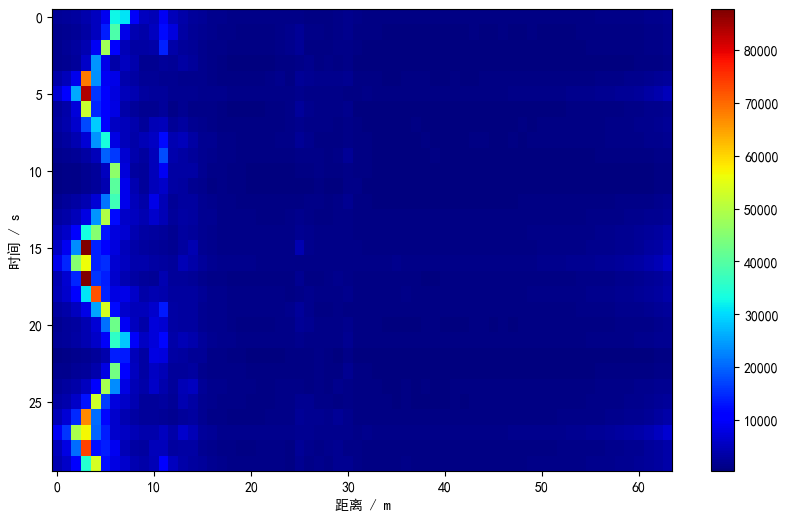

In [11]:
# 绘制距离-时间图
plt.figure(figsize=(10, 6))
plt.imshow(abs(range_profile[0,:,:]), cmap='jet', aspect='auto')
plt.xlabel('距离 / m')
plt.ylabel('时间 / s')
plt.colorbar()
plt.show()